In [13]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.linear_gaussian_ssm.inference import lgssm_smoother
from dynamax.linear_gaussian_ssm.models.linear_gaussian_ssm import LinearGaussianSSM

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

### Generate synthetic data and run HMC with all but covariance matrices frozen

In [12]:
# Simulate synthetic data from true model
state_dim = 2
emission_dim = 10
num_timesteps = 100
keys = map(jr.PRNGKey, count())

true_model = LinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.random_initialization(next(keys))
true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps)

# Initilize parameters by fitting EM algorithm
num_iters = 2000
test_model = LinearGaussianSSM(state_dim, emission_dim)
test_params, test_param_props = test_model.random_initialization(next(keys))

# Freeze transition parameters and inital parameters, so that only covariance matrices are learned
test_params["dynamics"]["weights"] = true_params["dynamics"]["weights"]
test_params["dynamics"]["bias"] = true_params["dynamics"]["bias"]
test_params["emissions"]["weights"] = true_params["emissions"]["weights"]
test_params["emissions"]["bias"] = true_params["emissions"]["bias"]
test_param_props["dynamics"]["weights"].trainable = False
test_param_props["dynamics"]["bias"].trainable = False
test_param_props["emissions"]["weights"].trainable = False
test_param_props["emissions"]["bias"].trainable = False


sample_size = 500
param_samples, lps = test_model.fit_hmc(test_params, test_param_props,
    next(keys), sample_size, emissions, num_integration_steps=30)


/Users/scott/Projects/dynamax-main/dynamax/abstractions.py:234: UserWarning: HMC is not currently computing logdets of the constrainer jacobians!
  warn("HMC is not currently computing logdets of the constrainer jacobians!")


Running window adaptation


100%|██████████| 500/500 [00:33<00:00, 14.96it/s]


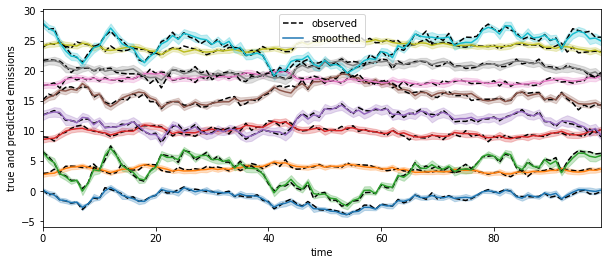

In [14]:
@jit
def smooth_emission(params):
    C = params['emissions']['weights']
    d = params['emissions']['bias']
    posterior = test_model.smoother(params, emissions)
    return posterior.smoothed_means @ C.T + d

smoothed_emissions = vmap(smooth_emission)(param_samples)
smoothed_emissions_means = smoothed_emissions.mean(axis=0)
smoothed_emissions_stds = jnp.std(smoothed_emissions, axis=0)

spc = 3
plt.figure(figsize=(10, 4))
for i in range(emission_dim):
    plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    ln = plt.plot(smoothed_emissions_means[:, i] + spc * i,
                  label="smoothed" if i == 0 else None)[0]
    plt.fill_between(
        jnp.arange(num_timesteps),
        spc * i + smoothed_emissions_means[:, i] - 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        spc * i + smoothed_emissions_means[:, i] + 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        color=ln.get_color(),
        alpha=0.25,
    )
plt.xlabel("time")
plt.xlim(0, num_timesteps - 1)
plt.ylabel("true and predicted emissions")
plt.legend()